In [1]:
using QuantumDynamics
using Plots
using LinearAlgebra

Hoping to get rid of the units issue by integrating Unitful into QuantumDynamics package.

In [2]:
const thz2au = 0.0001519828500716
const invcm2au = 4.55633e-6
const au2fs = 0.02418884254
const mev2invcm = 8.066
const nm2au = 18.897

5.29e-9

In [3]:
struct fitsd <: SpectralDensities.AnalyticalSpectralDensity
    ωs :: Vector{Float64}
    jws :: Vector{Float64}
    ωmax :: Real
    Δs :: Real
    classical :: Bool
end

Gaussian broadening distribution

In [4]:
σ = 25*invcm2au
function evaluate(sd::fitsd, ω::Real)
    ωs = sd.ωs
    jws = sd.jws
    
    s = 0.0
    for i in 1:(size(ωs)[1])
        s += jws[i]*exp(-(((ω-ωs[i])/σ)^2))
    end
    s
end

evaluate (generic function with 1 method)

In [5]:
(sd::fitsd)(ω::Real) = evaluate(sd, ω)

Ordejon paper mentions that Hamiltonian electronic terms are $\epsilon_0$ , $\epsilon_{AA+b}$ and $\epsilon_{AA+2b}$ for nearest 2 neighbours and additionally mentions that the coupling terms for nearest 2 neighbours on either side. Further mentions the couplings $\epsilon$AB, AC, AD for neighbours on the same unit cell. However, the value for $\epsilon_0$ (site energies) isn't mentioned in the paper? Perhaps worth doing some TD-DFT ourselves? Or alternatively some TrESP-ish method for 1-D... have to think about this for a bit

In [6]:
ϵ0 = -5000*mev2invcm # This appears to not change the dynamics at all
ϵb = 134.0
ϵ2b = -10.7

-10.7

In [7]:
N = 10

10

In [8]:
H0 = Matrix{ComplexF64}(zeros(N, N))

10×10 Matrix{ComplexF64}:
 0.0+0.0im  0.0+0.0im  0.0+0.0im  …  0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  …  0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im

In [9]:
for i in 1:N
    H0[i,i] = ϵ0
    if i <= N-2
        H0[i, i+2] = ϵ2b
    end
    if i <= N-1
        H0[i, i+1] = ϵb
    end
    if i >= 2
        H0[i, i-1] = ϵb
    end
    if i>=3
        H0[i, i-2] = ϵ2b
    end
end

In [10]:
H0 = H0 * invcm2au

10×10 Matrix{ComplexF64}:
   -0.183757+0.0im  0.000610548+0.0im  …          0.0+0.0im
 0.000610548+0.0im    -0.183757+0.0im             0.0+0.0im
 -4.87527e-5+0.0im  0.000610548+0.0im             0.0+0.0im
         0.0+0.0im  -4.87527e-5+0.0im             0.0+0.0im
         0.0+0.0im          0.0+0.0im             0.0+0.0im
         0.0+0.0im          0.0+0.0im  …          0.0+0.0im
         0.0+0.0im          0.0+0.0im             0.0+0.0im
         0.0+0.0im          0.0+0.0im     -4.87527e-5+0.0im
         0.0+0.0im          0.0+0.0im     0.000610548+0.0im
         0.0+0.0im          0.0+0.0im       -0.183757+0.0im

In [11]:
ωp = [57.8, 59.6, 89.0, 107.3, 139.1, 639.1, 1011.2, 1344.7, 1593.3] .* invcm2au
ωpg0p = [-1.7, 1.4, 1.6, -0.14, -2.3, -7.5, -3.6, 19.8, -42.0] * mev2invcm * invcm2au
#g0p = ωpg0p ./ ωp
jws = (ωpg0p .^ 2) ./ ωp
wm = maximum(ωp)
Jw = fitsd(ωp, jws, wm, 1.0, false)

fitsd([0.000263355874, 0.00027155726800000003, 0.00040551337, 0.0004888942090000001, 0.000633785503, 0.002911950503, 0.004607360896, 0.006126896951000001, 0.007259600589], [1.4821822592674006e-5, 9.748581302564107e-6, 8.526711424100102e-6, 5.414869018013244e-8, 1.127353580377361e-5, 2.6090675037956897e-5, 3.799264651919603e-6, 8.642444157405988e-5, 0.00032819550685341046], 0.007259600589, 1.0, false)

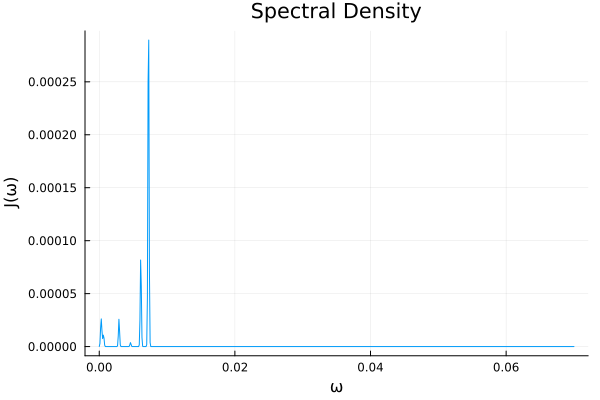

In [12]:
ω = 0:0.0001:0.07
plot(ω, Jw.(ω), xlabel="ω", ylabel="J(ω)", title="Spectral Density", legend=false)

In [13]:
nsteps = 50
ρ0 = Matrix{ComplexF64}(zeros(N, N))
ρ0[5, 5] = 1.0

T = 50.0:50.0:500.0

β = 1 / (T[6] * 3.16683e-6) # T = 300K

1052.5772881188234

Simulation is very sensitive to time-stepping. NaNs get produced if you're not careful

In [16]:
dt = 10/au2fs # 1fs

413.4137457575099

In [ ]:
d = 1.0  # intermolecular distances in 1D rubrene chain

In [ ]:
## QCPI Run

hb = Solvents.HarmonicBath(β, ωp, ωpg0p, [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0], 1000)
tc, ρc = QCPI.propagate(; Hamiltonian=H0, Jw, solvent=hb, ρ0, classical_dt=dt / 100, dt, ntimes=nsteps, kmax=1, svec=[1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0], extraargs=QuAPI.QuAPIArgs(), path_integral_routine=QuAPI.propagate)

In [18]:
MSD = []
for i in 1:50
    s = 0.0
    for j in 1:N
        s += real(ρc[i, j, j])*(j-5)^2
    end
    push!(MSD, s)
end

In [19]:
display("text/plain", MSD)

50-element Vector{Any}:
 0.0
 1.2017953976459468e-16
 2.0411980897970004e-16
 2.9069500998123185e-16
 3.682843296786691e-16
 4.519579499604254e-16
 5.344713694938517e-16
 6.117503880059245e-16
 6.853303629016396e-16
 7.615419517781604e-16
 8.2576452466768e-16
 8.964884049198783e-16
 9.44898770661731e-16
 ⋮
 3.019979462733291e-15
 3.1035360818345357e-15
 3.2302528197293145e-15
 3.3250385438499362e-15
 3.4008736177883793e-15
 3.492049728544631e-15
 3.6094062651557845e-15
 3.6840089671451004e-15
 3.7901777308779375e-15
 3.901039143272249e-15
 4.00600692419454e-15
 4.0868737556373974e-15

In [21]:
μ = β * (MSD[50] - MSD[1])/((tc[50] - tc[1])*au2fs)

4.3895413210130635e-15

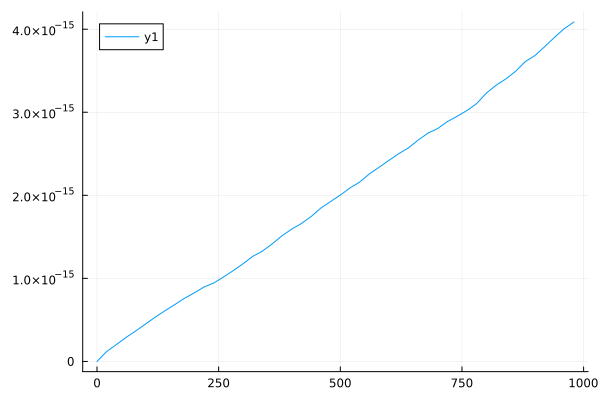

In [23]:
plot(tc[1:50].*au2fs, MSD, fmt= :png)

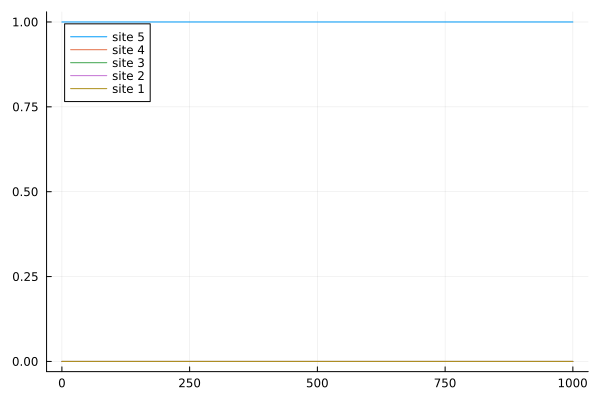

In [25]:
plot(tc.*au2fs, real.(ρc[:, 5, 5]), label="site 5")
plot!(tc.*au2fs, real.(ρc[:, 4, 4]), label="site 4")
plot!(tc.*au2fs, real.(ρc[:, 3, 3]), label="site 3")
plot!(tc.*au2fs, real.(ρc[:, 2, 2]), label="site 2")
plot!(tc.*au2fs, real.(ρc[:, 1, 1]), label="site 1")

In [17]:
fbU = Propagators.calculate_bare_propagators(; Hamiltonian=H0, dt=dt, ntimes=nsteps)    
t, ρ = TTM.propagate(; fbU=fbU, Jw=[Jw], β=β, ρ0=ρ0, dt=dt, ntimes=nsteps, rmax=1, extraargs=QuAPI.QuAPIArgs(), path_integral_routine=QuAPI.build_augmented_propagator)

(0.0:413.4137457575099:20670.687287875495, [0.0 + 0.0im 0.0 + 0.0im … 0.0 + 0.0im 0.0 + 0.0im; 3.989717981968823e-7 + 0.0im -1.8247714627557142e-6 + 3.0384781419489124e-6im … 3.97180716203157e-7 + 1.7008026011037532e-9im -2.479236859935095e-8 - 3.4883686029187686e-8im; … ; 0.08962580886420476 - 0.0002541465989014413im -0.09278037892849042 - 0.04695192790095253im … 0.09700827290269037 + 0.0136283936634804im 0.011366871671165823 - 0.01687241626490559im; 0.07127231779485402 + 6.051654666247423e-5im -0.10639774379210594 - 0.029284931958728874im … 0.0961512363147316 + 0.010255514781020474im 0.0032212238402248134 - 0.0430595807471853im;;; 0.0 + 0.0im 0.0 + 0.0im … 0.0 + 0.0im 0.0 + 0.0im; -1.8207340151760145e-6 - 3.031755274745775e-6im 3.148628641714132e-5 + 0.0im … -1.803626692937507e-6 - 3.0326166062497306e-6im -1.5227369721530788e-7 + 3.4836002315500603e-7im; … ; -0.09147456113203423 + 0.04725240323448942im 0.11791279406637732 - 0.0012670063184734937im … -0.10497185345909106 + 0.035640795

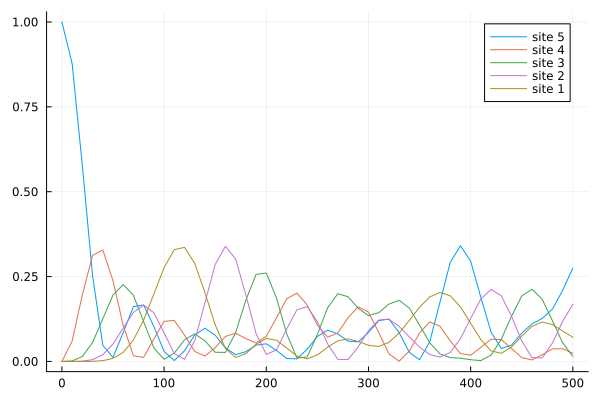

In [18]:
plot(t.*au2fs, real.(ρ[:, 5, 5]), label="site 5")
plot!(t.*au2fs, real.(ρ[:, 4, 4]), label="site 4")
plot!(t.*au2fs, real.(ρ[:, 3, 3]), label="site 3")
plot!(t.*au2fs, real.(ρ[:, 2, 2]), label="site 2")
plot!(t.*au2fs, real.(ρ[:, 1, 1]), label="site 1")